In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
os.environ["WANDB_API_KEY"] = "0" 
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [3]:
tf.test.gpu_device_name()

''

In [3]:
dir = os.listdir('../input/plant-village/PlantVillage')
for filenames in dir:
    print(filenames)

Pepper__bell___Bacterial_spot
Potato___healthy
Tomato_Leaf_Mold
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_Bacterial_spot
Tomato_Septoria_leaf_spot
Tomato_healthy
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato_Early_blight
Tomato__Target_Spot
Pepper__bell___healthy
Potato___Late_blight
Tomato_Late_blight
Potato___Early_blight
Tomato__Tomato_mosaic_virus


In [5]:
!cp -rf ../input/plant-village/PlantVillage/Tomato_Early_blight ./Tomato_Early_blight

In [5]:
!cp -rf ../input/plant-village/PlantVillage/Tomato_Bacterial_spot ./Tomato_Bacterial_spot

In [6]:
!cp -rf ../input/plant-village/PlantVillage/Tomato_Late_blight ./Tomato_Late_blight

In [7]:
!cp -rf ../input/plant-village/PlantVillage/Tomato_healthy ./Tomato_healthy

In [8]:
!cp -rf ../input/plant-village/PlantVillage/Potato___healthy ./Potato___healthy

In [9]:
!cp -rf ../input/plant-village/PlantVillage/Tomato_Leaf_Mold ./Tomato_Leaf_Mold

In [10]:
!cp -rf ../input/plant-village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus ./Tomato__Tomato_YellowLeaf__Curl_Virus

In [11]:
!cp -rf ../input/plant-village/PlantVillage/Tomato_Septoria_leaf_spot ./Tomato_Septoria_leaf_spot

In [12]:
!cp -rf ../input/plant-village/PlantVillage/Tomato_Septoria_leaf_spot ./Tomato_Septoria_leaf_spot

In [13]:
!cp -rf ../input/plant-village/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite ./Tomato_Spider_mites_Two_spotted_spider_mite

In [14]:
!cp -rf ../input/plant-village/PlantVillage/Tomato__Target_Spot ./Tomato__Target_Spot

In [15]:
!cp -rf ../input/plant-village/PlantVillage/Potato___Late_blight ./Potato___Late_blight

In [16]:
!cp -rf ../input/plant-village/PlantVillage/Potato___Early_blight ./Potato___Early_blight

In [17]:
!cp -rf ../input/plant-village/PlantVillage/Tomato__Tomato_mosaic_virus ./Tomato__Tomato_mosaic_virus

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 64 # reduce the dimension
CHANNELS=3
EPOCHS=50
FILE_PATH  = "/kaggle/working/"

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory='../input/plant-village/PlantVillage',
            shuffle=True,
            image_size=(IMAGE_SIZE,IMAGE_SIZE),
            batch_size = BATCH_SIZE,
)

Found 20638 files belonging to 15 classes.


2022-11-25 17:51:03.710262: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
classnames = dataset.class_names
classnames

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

## Exploring images in a single Batch

In [7]:
for img, label in dataset.take(1):
    print(img[0].numpy())
    print(img[0].shape)
    print(label.numpy())

2022-11-25 17:51:21.625906: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


[[[150.   151.   172.  ]
  [151.75 152.75 173.75]
  [142.75 143.75 164.75]
  ...
  [138.75 134.75 148.75]
  [150.75 146.75 160.75]
  [165.5  161.5  175.5 ]]

 [[150.25 151.25 172.25]
  [148.25 149.25 170.25]
  [142.75 143.75 164.75]
  ...
  [135.75 131.75 145.75]
  [153.75 149.75 163.75]
  [140.25 136.25 150.25]]

 [[148.75 149.75 170.75]
  [151.5  152.5  173.5 ]
  [157.   158.   179.  ]
  ...
  [149.5  145.5  159.5 ]
  [138.75 134.75 148.75]
  [169.   165.   179.  ]]

 ...

 [[175.25 173.25 187.25]
  [163.75 161.75 175.75]
  [172.   170.   184.  ]
  ...
  [155.75 149.75 161.75]
  [159.25 153.25 165.25]
  [151.75 145.75 157.75]]

 [[174.25 172.25 186.25]
  [172.25 170.25 184.25]
  [163.75 161.75 175.75]
  ...
  [147.5  141.5  153.5 ]
  [146.75 140.75 152.75]
  [152.5  146.5  158.5 ]]

 [[169.5  167.5  181.5 ]
  [174.25 172.25 186.25]
  [160.   158.   172.  ]
  ...
  [154.25 148.25 160.25]
  [133.75 127.75 139.75]
  [156.75 150.75 162.75]]]
(64, 64, 3)
[ 9  7 11  5  3  9  1  1 12 12  5 

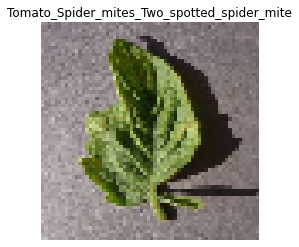

In [8]:
for img, label in dataset.take(1):
    plt.imshow(img[0].numpy().astype('uint8'))
    plt.axis('off')
    plt.title(classnames[label[0].numpy()])

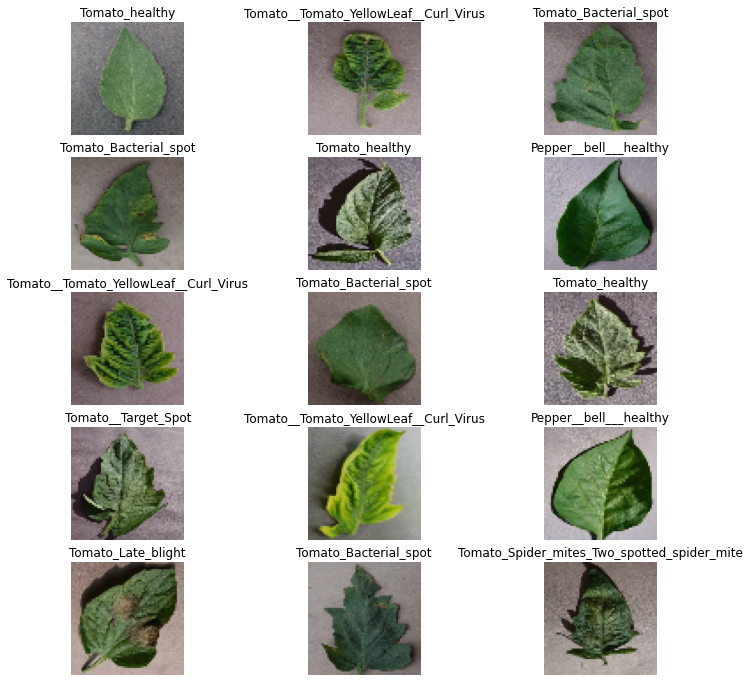

In [9]:
plt.figure(figsize=(12,12))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        plt.subplot(5,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(classnames[label_batch[i]])

In [11]:
train_data_size = 0.8
len(dataset)*train_data_size

516.0

In [12]:
train_data = dataset.take(454)
len(train_data)

454

In [13]:
test_data = dataset.skip(454)
len(test_data)

191

In [14]:
val_data = dataset.take(30)
len(val_data)

30

In [8]:
def get_dataset_partitions_tf(data, val_split=0.1, train_split=0.8, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    data_size = len(data)
    
    if shuffle:
        data = data.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)
    
    train_data = data.take(train_size)    
    val_data = data.skip(train_size).take(val_size)
    test_data = data.skip(train_size).skip(val_size)
    
    return train_data, val_data, test_data

In [5]:
train_data, val_data, test_data = get_dataset_partitions_tf(dataset)

In [6]:
len(train_data)

516

In [7]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
rescale_and_resize = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [9]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

model = models.Sequential([
    rescale_and_resize,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (32, 30, 30, 64)         

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_data,
    batch_size=BATCH_SIZE,
    validation_data=val_data,
    verbose=1,
    epochs=10,
)

Epoch 1/10
516/516 [==============================] - ETA: 0s - loss: 1.6987 - accuracy: 0.4451

Cleanup called...
2022-11-12 23:29:50.222932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 528 of 10000
2022-11-12 23:29:54.830923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-11-12 23:29:54.833379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-11-12 23:29:54.833640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


516/516 [==============================] - 713s 1s/step - loss: 1.6987 - accuracy: 0.4451 - val_loss: 1.1206 - val_accuracy: 0.5928
Epoch 2/10
516/516 [==============================] - 714s 1s/step - loss: 0.8176 - accuracy: 0.7217 - val_loss: 0.6086 - val_accuracy: 0.7944
Epoch 3/10
516/516 [==============================] - 700s 1s/step - loss: 0.5550 - accuracy: 0.8119 - val_loss: 0.5040 - val_accuracy: 0.8149
Epoch 4/10
516/516 [==============================] - 702s 1s/step - loss: 0.4204 - accuracy: 0.8559 - val_loss: 0.4403 - val_accuracy: 0.8521
Epoch 5/10
516/516 [==============================] - 711s 1s/step - loss: 0.3424 - accuracy: 0.8812 - val_loss: 0.2953 - val_accuracy: 0.8945
Epoch 6/10
516/516 [==============================] - 718s 1s/step - loss: 0.2917 - accuracy: 0.8997 - val_loss: 0.2497 - val_accuracy: 0.9160
Epoch 7/10
516/516 [==============================] - 715s 1s/step - loss: 0.2518 - accuracy: 0.9113 - val_loss: 0.1948 - val_accuracy: 0.9292
Epoch 8/10

In [18]:
model.save("Shreyansh_Upadhyay_6614.h5")

In [9]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(15,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model